<a href="https://colab.research.google.com/github/Mandersss/AML-AVGAN-22/blob/main/Part1_A_V_Seperation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <b> <font color = Maroon > Name(s): </font>Armando Revelez, Nat Rojvachiranonda 
## <b> <font color = Maroon> Course: </font> AML ECE5995
## <font color = Maroon> Project: </font> Artery & Vein Separation (A/V Segmentation) from CT/CTA Scans </b>


In [ ]:
# !pip install torchvision
# !pip install gdown

In [5]:
# ---- PRELIMINARY IMPORTS ---- #

# sklearn
from sklearn.model_selection import train_test_split

# torch imports
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

valid_ratio = 0.3

# torch vision
import torchvision
import torchvision.transforms as transforms #####S1? redundant --
import torchvision.transforms as T
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import InterpolationMode
import PIL #####S2 redundant?
from PIL import Image

# Supporting Libraries
import gdown
import os
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# Data imports
# !pip install SimpleITK
# !pip install google.colab

import SimpleITK as sitk
# from google.colab import files

## <b> <font color = orange>  UNet Architecture </font> </b>
Intention: 
- Reduce image down and rebuild with segmentation knowledge
- Utilize bridge information between early stages and latter stages (grey arrows) to provide additional reference as image is segmented
- This bridge connects what is called a <font color = red> <b> Semantic Gap </b> </font>
- Semantic Definition - <font color = lightblue> "Relating to meaning in language or logic" </font>
- Meaning consecutive convolutions leading to segmented images can reference earlier stages of the image to supplement the outcome.


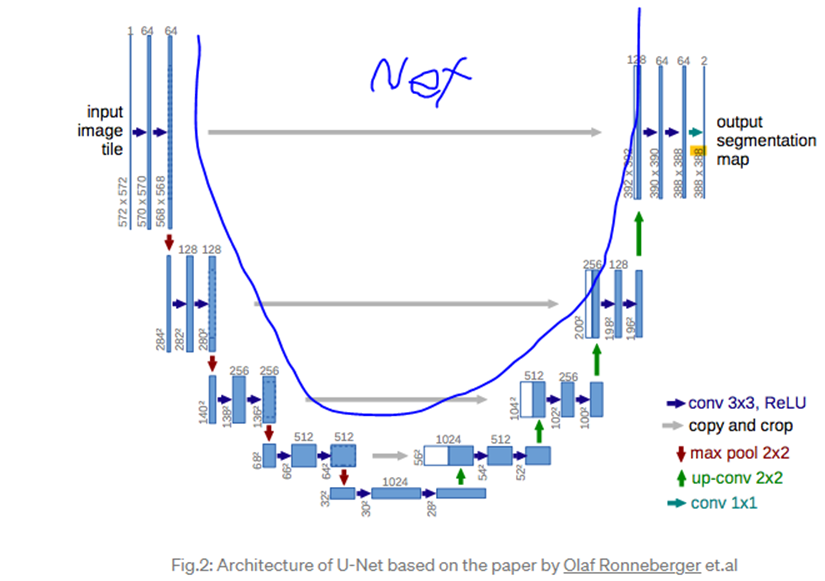

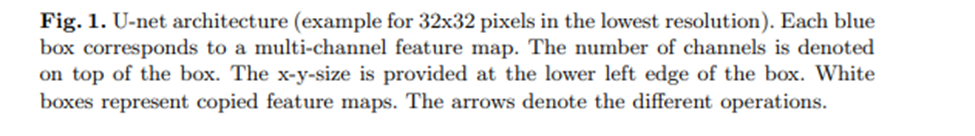

## <b> <font color = orange>  UNet++ <font color = red> : NOT USING</font> </font> </b>
Why is it differnt: 
- UNet++ modifies the bridges of the semantic gap to interconnect more information into the segmented image output using convolutions (As shown in next cell)
- In the image below the LHS dotted rectangle is the "backbone" / encoder / left side of the "U" from the above image. 
- The RHS is the decoder / right side of the "U" 
- The area in between is filled with convolutional layers that essentially compile information from all stages of the NN to provide more detailed information to the decoder stage. This adds more detail to the bridges that connected semantic gaps in UNet. 

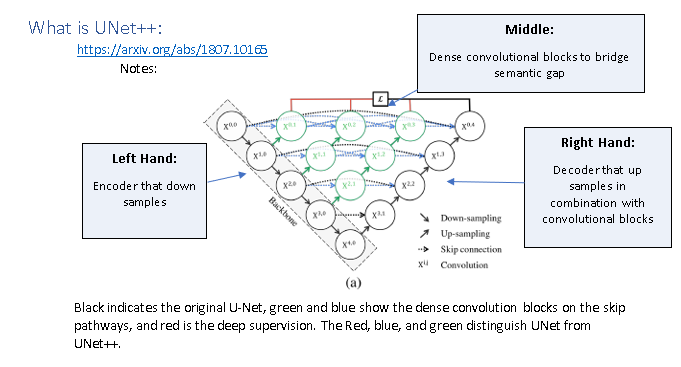

#<b> <font color = Maroon> Step 1 </font> : Create UNet CNN Pytorch definition<font color=red> </b>
* Derived from Unet implementation (https://github.com/zhixuhao/unet/blob/master/model.py) implemented with Keras, and the above visual of UNet from it's original research paper

* UNet++ will be a secondary goal to improve the segmentation, since it involves complex convolutional connections
## <b> <font color = green>Aim to produce segmented images from the network </font> </b>
* Data Configuration: 
  * Lung CT scans for a 3D volume of slices:
  * (<font color = orange> 512x512 </font>) Image Area * (<font color = orange> 400 </font> ) Slices Tall  
  * Voxel value 0 - 255
* Network Training:
  * Provided the correclty labeled data compare the network output to determine loss and accuracy 




## <b> <font color = Maroon> Extended stage by stage definition of UNet (By Mando)  </font>

In [4]:
"""
 # ---- V1 IMPLMENTATION ---- #
 #:v1
 # Description: 
 # ... This version implments UNet as seen in the photograph where the dimensions are reduced 
"""
class UNet_V1(nn.Module):
  def __init__(self):
    super(UNet_V1, self).__init__()

    ###-------------------------- ENCODER STAGE ------------------------ ###
    ######## ENCODER BLOCK 1 : - Sequential definition:
    self.ENCODER_BL1 = unet_block(1,64,1)
    # MaxPool1: Output dims = .5 Input dims
    self.MAXPOOL_1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    ######## ENCODER BLOCK 2 : - Sequential definition:
    self.ENCODER_BL2 = unet_block(64,128,1)
    # MaxPool2: Output dims = .5 Input dims
    self.MAXPOOL_2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    ######## ENCODER BLOCK 3 :
    # Enocder block 3 - Sequential definition:
    self.ENCODER_BL3 = unet_block(128,256,1)
    # MaxPool3: Output dims = .5 Input dims
    self.MAXPOOL_3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    ######## ENCODER BLOCK 4 : - Sequential definition:
    self.ENCODER_BL4 = unet_block(256,512,1)
    # MaxPool4: Output dims = .5 Input dims
    self.MAXPOOL_4 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    ######## ENCODER BLOCK 5 : Sequential definition:
    self.ENCODER_BL5 = unet_block(512,1024,1)

    # Encoder to Decoder transition...
    ###------------------------- SEMANTIC GAP ---------------------------###

    # For UNet++ this would include a bunch of convolutions

    #--------------------------- DECODER STAGE --------------------------- #
    # Decoder Stage ... 

    # UpConv1: 3x3 inchannels 1024, outchannels 512, input Pxl X Pxl
    self.UPCONV_1 = upconv(1024,512)

    # Semantic Gap Info Passoff 4 ....
    # Concatinate = ENCODER_BL4 output + ENCODER_BL5 output 

    ######## DECODER BLOCK 1 : - Sequential definition:
    self.DECODER_BL1 = unet_block(1024,512,1)

    # UpConv2: 3x3 inchannels 512, outchannels 256, input Pxl X Pxl
    self.UPCONV_2 = upconv(512,256)

    # Semantic Gap Info Recieve 3 ....

    ######## DECODER BLOCK 2 : - Sequential definition:
    self.DECODER_BL2 = unet_block(512,256,1)
    
    # UpConv3: 3x3 inchannels 256, outchannels 128, input Pxl X Pxl
    self.UPCONV_3 = upconv(256,128)

    # Semantic Gap Info Recieve 2 ....

    ######## DECODER BLOCK 3 : - Sequential definition:
    self.DECODER_BL3 = unet_block(256, 128,1)

    # UpConv4: 3x3 inchannels 128, outchannels 64, input Pxl X Pxl
    self.UPCONV_4 = upconv(128,64)

    # Semantic Gap Info Recieve 1 ....

    ####### DECODER BLOCK 4 - Sequential definition:
    self.DECODER_BL4 = unet_block(128,64,1)

    # Conv9c: 1x1 inchannels 64, outchannels 2, input Pxl X Pxl
    self.conv_END = nn.Sequential(
      nn.Conv2d(64, 1, kernel_size=1,  dilation = 1, stride=1, padding=0)
    ) 
          
  def forward(self, x):
    # ----  IMPLEMENTATION ---- #
    ######## ENCODER BACKBONE  
    # print("Before Encoder 1: ", x.shape)
    x1 = self.ENCODER_BL1(x)
    # print("After Encoder 1: ", x1.shape)
    m1 = self.MAXPOOL_1(x1)
    # print("After Maxpool 1: ", m1.shape)

    # Passoff x1

    # print("Before Encoder 2: ", m1.shape)
    x2 = self.ENCODER_BL2(m1)
    # print("After Encoder 2: ", x2.shape)
    m2 = self.MAXPOOL_2(x2)
    # print("After Maxpool 1: ", m2.shape)

    # Passoff x2

    # print("Before Encoder 3: ", m2.shape)
    x3 = self.ENCODER_BL3(m2)
    # print("After Encoder 3: ", x3.shape)
    m3 = self.MAXPOOL_3(x3)
    # print("After Maxpool 1: ", m3.shape)

    # Passoff x3

    # print("Before Encoder 4: ", m3.shape)
    x4 = self.ENCODER_BL4(m3)
    # print("After Encoder 4: ", x4.shape)
    m4 = self.MAXPOOL_4(x4)
    # print("After Maxpool 1: ", m4.shape)

    # Passoff x4

    # print("Before Encoder 5: ", m4.shape)
    x5 = self.ENCODER_BL5(m4)
    # print("After Encoder 5: ", x5.shape)

    ######## SEMANTIC GAP 


    ######## DECODER SECTION 

    # print("Before UpConv: ", x5.shape)
    u1 = self.UPCONV_1(x5)
    # print("After UpConv: ", u1.shape)

    x41 = copy_crop(x4,u1)

    # print("Before Decoder 1: ", x41.shape)
    x7 = self.DECODER_BL1(x41)
    # print("After Decoder 1: ", x7.shape)

    # print("Before UpConv2: ", x7.shape)
    u2 = self.UPCONV_2(x7)
    # print("After UpConv2: ", u2.shape)

    x32 = copy_crop(x3,u2)

    # print("Before Decoder 2: ", x32.shape)
    x8 = self.DECODER_BL2(x32)
    # print("After Decoder 2: ", x8.shape)

    # print("Before UpConv3: ", x8.shape)
    u3 = self.UPCONV_3(x8)
    # print("After UpConv3: ", u3.shape)

    x23 = copy_crop(x2,u3)

    # print("Before Decoder 3: ", x23.shape)
    x9 = self.DECODER_BL3(x23)
    # print("After Decoder 3: ", x9.shape)

    # print("Before UpConv4: ", x9.shape)
    u4 = self.UPCONV_4(x9)
    # print("After UpConv3: ", u4.shape)

    x14 = copy_crop(x1,u4)
    
    # print("Before Decoder 4: ", x14.shape)
    x10 = self.DECODER_BL4(x14)
    # print("After Decoder 4: ", x10.shape)

    x_out = self.conv_END(x10)
    # print("After final convolution: ", x_out.shape)

    return x_out

"""
 # ---- V2 IMPLMENTATION ---- #
 #:v2
 # Description: 
 # ... This version alters the convolutional blocks to rebuild an image of the same size as the original.
 # ... This caters to an attempt at image segmenatation based on the UNet Architecture
"""
class UNet_V2(nn.Module):
  def __init__(self):
    super(UNet_V2, self).__init__()

    ###-------------------------- ENCODER STAGE ------------------------ ###
    ######## ENCODER BLOCK 1 : - Sequential definition:
    self.ENCODER_BL1 = unet_block(1,64,2)
    # MaxPool1: Output dims = .5 Input dims
    self.MAXPOOL_1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    ######## ENCODER BLOCK 2 : - Sequential definition:
    self.ENCODER_BL2 = unet_block(64,128,2)
    # MaxPool2: Output dims = .5 Input dims
    self.MAXPOOL_2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    ####### DROPOUT LAYER #######
    # self.drop1 = nn.Dropout(p = .5, inplace = False)

    ######## ENCODER BLOCK 3 :
    # Enocder block 3 - Sequential definition:
    self.ENCODER_BL3 = unet_block(128,256,2)
    # MaxPool3: Output dims = .5 Input dims
    self.MAXPOOL_3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    ######## ENCODER BLOCK 4 : - Sequential definition:
    self.ENCODER_BL4 = unet_block(256,512,2)
    # MaxPool4: Output dims = .5 Input dims
    self.MAXPOOL_4 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    ####### DROPOUT LAYER #######
    self.drop2 = nn.Dropout(p = .5, inplace = False)
    
    # Encoder to Decoder transition...

    ######## ENCODER BLOCK 5 : Sequential definition:
    self.ENCODER_BL5 = unet_block(512,1024,2)
    
    ###------------------------- SEMANTIC GAP ---------------------------###

    # For UNet++ this would include a bunch of convolutions

    #--------------------------- DECODER STAGE --------------------------- #
    # Decoder Stage ... 

    # UpConv1: 3x3 inchannels 1024, outchannels 512, input Pxl X Pxl
    self.UPCONV_1 = upconv(1024,512)

    # Semantic Gap Info Passoff 4 ....
    # Concatinate = ENCODER_BL4 output + ENCODER_BL5 output 

    ######## DECODER BLOCK 1 : - Sequential definition:
    self.DECODER_BL1 = unet_block(1024,512,2)

    # UpConv2: 3x3 inchannels 512, outchannels 256, input Pxl X Pxl
    self.UPCONV_2 = upconv(512,256)

    # Semantic Gap Info Recieve 3 ....

    ######## DECODER BLOCK 2 : - Sequential definition:
    self.DECODER_BL2 = unet_block(512,256,2)
    
    # UpConv3: 3x3 inchannels 256, outchannels 128, input Pxl X Pxl
    self.UPCONV_3 = upconv(256,128)

    ####### DROPOUT LAYER #######
    # self.drop3 = nn.Dropout(p = .5, inplace = False)    

    # Semantic Gap Info Recieve 2 ....

    ######## DECODER BLOCK 3 : - Sequential definition:
    self.DECODER_BL3 = unet_block(256, 128,2)

    # UpConv4: 3x3 inchannels 128, outchannels 64, input Pxl X Pxl
    self.UPCONV_4 = upconv(128,64)

    # Semantic Gap Info Recieve 1 ....

    ####### DECODER BLOCK 4 - Sequential definition:
    self.DECODER_BL4 = unet_block(128,64,2)

    # Conv9c: 1x1 inchannels 64, outchannels 2, input Pxl X Pxl
    self.conv_END = nn.Sequential(
      nn.Conv2d(64, 1, kernel_size=1,  dilation = 1, stride=1, padding=0)
    ) 

    # Initialize the weights
    self._initialize_weights()
  
  def _initialize_weights(self) -> None:
    for module in self.modules():
        if isinstance(module, nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            #nn.init.normal_(module.weight.data, 0.0, math.sqrt(2 / (module.out_channels * module.weight.data[0][0].numel())))
            nn.init.zeros_(module.bias.data)

  def forward(self, x):
    # ----  IMPLEMENTATION ---- #
    ######## ENCODER BACKBONE  
    # print("Before Encoder 1: ", x.shape)
    x1 = self.ENCODER_BL1(x)
    # print("After Encoder 1: ", x1.shape)
    m1 = self.MAXPOOL_1(x1)
    # print("After Maxpool 1: ", m1.shape)

    # Passoff x1
    # print("Before Encoder 2: ", m1.shape)
    x2 = self.ENCODER_BL2(m1)
    # print("After Encoder 2: ", x2.shape)
    m2 = self.MAXPOOL_2(x2)
    # print("After Maxpool 2: ", m2.shape)

    # Passoff x2

    # print("Before Encoder 3: ", m2.shape)
    x3 = self.ENCODER_BL3(m2)
    # print("After Encoder 3: ", x3.shape)
    m3 = self.MAXPOOL_3(x3)
    # print("After Maxpool 3: ", m3.shape)

    # Passoff x3
    # print("Before Encoder 4: ", m3.shape)
    x4 = self.ENCODER_BL4(m3)
    # print("After Encoder 4: ", x4.shape)
    m4 = self.MAXPOOL_4(x4)
    # print("After Maxpool 4: ", m4.shape)

    # Passoff x4
    # print("Before Encoder 5: ", m4.shape)
    x5 = self.ENCODER_BL5(self.drop2(m4))
    # print("After Encoder 5: ", x5.shape)

    ######## SEMANTIC GAP 


    ######## DECODER SECTION 
    # print("Before UpConv: ", x5.shape)
    u1 = self.UPCONV_1(x5) 
    # print("After UpConv: ", u1.shape)

    x41 = copy_crop(x4,u1)

    # print("Before Decoder 1: ", x41.shape)
    x7 = self.DECODER_BL1(x41)
    # print("After Decoder 1: ", x7.shape)

    # print("Before UpConv2: ", x7.shape)
    u2 = self.UPCONV_2(x7)
    # print("After UpConv2: ", u2.shape)

    x32 = copy_crop(x3,u2)

    # print("Before Decoder 2: ", x32.shape)
    x8 = self.DECODER_BL2(x32)
    # print("After Decoder 2: ", x8.shape)

    # print("Before UpConv3: ", x8.shape)
    u3 = self.UPCONV_3(x8)
    # print("After UpConv3: ", u3.shape)

    x23 = copy_crop(x2,u3)

    # print("Before Decoder 3: ", x23.shape)
    x9 = self.DECODER_BL3(x23)
    # print("After Decoder 3: ", x9.shape)

    # print("Before UpConv4: ", x9.shape)
    u4 = self.UPCONV_4(x9)
    # print("After UpConv3: ", u4.shape)

    x14 = copy_crop(x1,u4)
    
    # print("Before Decoder 4: ", x14.shape)
    x10 = self.DECODER_BL4(x14)
    # print("After Decoder 4: ", x10.shape)

    x_out = self.conv_END(x10)
    # print("After final convolution: ", x_out.shape)

    return x_out

"""
# Name: copy_crop
# Paramaters: Encoder output tensor, up convolution tensor
# Details:
# ... When each semantic gap is bridged, it is described as a "Copy and crop".
# ... It copies the output of the encoder block, to be received and included in the decoding stage.
# ... The tensor from the encoder stage must have it's image dimension cropped to fit the up convolution, ....
# ... THE CHANNELS from the up convolution and encoder stage output ARE CONCATINATED. ...
# ... Each decoder stage eventually produces the segemnted output.
"""
def copy_crop(enc_out, up_conv):    
    # Trim the image dimensions to fit
    enc_out_crop = T.functional.crop(enc_out,
                                      0,0, # Crop from origin
                                      up_conv.shape[2], # Trim photo to dimensions of x6
                                      up_conv.shape[2])
    
    # Concat - enc_out + up_conv, enc_out > up_conv -> trim encoder output to match up_conv
    dec_in = torch.cat((up_conv,enc_out_crop),1)
   
    return dec_in

"""
# Name: unet_block
# Parameters,1: in/out channels
# Description: 
# ... UNet Encoder/Decoder block re-usable definition. 
# ... Each block reduces the image dimensions by 4, and halves the input channels.
"""
def unet_block(inchannels,outchannels,version):
  # Reduce down image dimensions as in the original paper
  if version == 1:
    return nn.Sequential(
        nn.Conv2d(inchannels, outchannels, kernel_size=3, stride=1, padding=0, dilation =1),
        nn.ReLU(True),
        nn.Conv2d(outchannels, outchannels, kernel_size=3, stride=1, padding=0, dilation =1),
        nn.ReLU(True)
      ) 
  # Modify the convolutions to retain and rebuild the original dimensions
  elif version == 2:
    return nn.Sequential(
        nn.Conv2d(inchannels, outchannels, kernel_size=3, stride=1, padding=1, dilation =1),
        nn.ReLU(True),
        nn.Conv2d(outchannels, outchannels, kernel_size=3, stride=1, padding=1, dilation =1),
        nn.ReLU(True)
      ) 
    

"""
# Name: upconv
# Parameters: in/out channels
# Description: 
# ... Up-convolution consisting of a convolution and an upsample.
"""
def upconv(inchannels,outchannels):
  return nn.Sequential(
        nn.Conv2d(inchannels, outchannels, kernel_size=2, stride=1, padding=1, dilation =2),
        nn.Upsample(scale_factor=2,mode ='bilinear',align_corners=False)
    )


## <font color = Maroon><b> Efficiently condensed UNet definition (By Nat) </b> </font> :

In [5]:
"""
Generic UNet block
"""
class Block(nn.Module):
  def __init__(self,inCh,outCh):
    super(Block,self).__init__()

    self.conv1 = nn.Conv2d(inCh,outCh,kernel_size=3,padding='same')
    self.conv2 = nn.Conv2d(outCh,outCh,kernel_size=3,padding='same')

  def forward(self,x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)

    return x

"""
Encoder Stage block
"""
class Enc(nn.Module):
  def __init__(self,channels=(1,64,128,256,512,1024)):
    super(Enc,self).__init__()

    self.encBlocks = nn.ModuleList([Block(channels[i],channels[i+1]) for i in range(len(channels)-1)])

    self.pool = nn.MaxPool2d(kernel_size=2)

  def forward(self,x):
    trans = []
    for blocks in self.encBlocks:
      x = blocks(x)
      trans.append(x)
      x = self.pool(x)

    return trans

"""
Decoder Stage block
"""
class Dec(nn.Module):
  def __init__(self,channels=(1024,512,256,128,64)):
    super(Dec,self).__init__()
    self.channels = channels
    self.upconv = nn.ModuleList([nn.ConvTranspose2d(channels[i],channels[i+1],kernel_size=2,stride=2) for i in range(len(channels)-1)])
    self.decBlocks = nn.ModuleList([Block(channels[i],channels[i+1]) for i in range(len(channels)-1)])

  def forward(self,x,encFeat):
    for i in range(len(self.channels)-1):
      x = self.upconv[i](x)
      encTrans = self.crop(encFeat[i],x)
      x = torch.cat([x,encTrans],dim=1)
      x = self.decBlocks[i](x)
    return x

  def crop(self,encTrans,x):
    a,b,H,W = x.shape
    encTrans = T.CenterCrop([H,W])(encTrans)
    return encTrans

"""
Condensed Unet block definition
"""
class UNet(nn.Module):
  def __init__(
      self,
      encChannels = (1,64,128,256,512,1024),
      decChannels = (1024,512,256,128,64),
      noClass = 1,
      outSize = (572,572)
  ):
    super(UNet,self).__init__()
    
    self.enc = Enc(encChannels)
    self.dec = Dec(decChannels)
    self.head = nn.Conv2d(decChannels[-1],noClass,kernel_size=1,padding='same')
    self.outSize = outSize

  def forward(self,x):
    encTrans = self.enc(x)
    out = self.dec(encTrans[::-1][0], encTrans[::-1][1:])
    out = self.head(out)
    
    # out = F.interpolate(out,self.outSize)
    return out

## <font color = red> Dont run this section! (Original scratch testing ) </font>
### **Pytorch function testing & Network pass through verificaiton** 

In [ ]:
"""
# ------------------------------------------------- #
# ------------  PYTORCH TESTING BLOCK  ------------ #
"""
import torch.nn as nn
import torch.nn.functional as F

m1 = nn.Conv2d(in_channels =6, out_channels = 32,kernel_size = 4, stride=1,padding = 1)
m2 = nn.Conv2d(in_channels =6, out_channels = 12,kernel_size = 9, stride=1,padding = 3)
P = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

input = torch.randn(20, 6, 32,32) # Assume this is 4D?


output = m1(input)
output2 = P(input)
output3 = m2(input)

print(type(input))
print("\n Input tensor: \t\t\t",input.shape,
      "\n Conv2d kernal 3: \t\t",output.shape,
      "\n Conv2d kernal 6: \t\t",output3.shape,
      '\n MaxPool2D: \t\t\t',output2.shape)

<class 'torch.Tensor'>

 Input tensor: 			 torch.Size([20, 6, 32, 32]) 
 Conv2d kernal 3: 		 torch.Size([20, 32, 31, 31]) 
 Conv2d kernal 6: 		 torch.Size([20, 12, 30, 30]) 
 MaxPool2D: 			 torch.Size([20, 6, 16, 16])


In [ ]:
# Random testing

# Did this to re-update net everytime I tweaked optimizers
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

testInput = torch.rand(1,1,512,512).to(device)
net = UNet_V1().to(device)
net2 = UNet_V2().to(device)

outputs = net2(testInput)

# print("\n Input size: ", testInput.shape)
# print("\n Cropping test:", T.functional.crop(testInput, 0,0,testInput.shape[2] -1 - 10,testInput.shape[3] - 1- 10).shape)
# print("\n Padding test: ", F.pad(testInput,(0,0,
#                                             0,0,
#                                             4,5,
#                                             0,0,)).shape )


# <font color = Maroon><b> Step 2</b> </font> : Define dataloader class, load the CT/CTA images, create transforms, and generate training and testing sets.

In [9]:
"""
  # Class name: CT_Slices_Dataset
  # Parameters:
  #     - CT_Scan (ndarray): 3D volume with a number of image slices  
  #     - image_size (int): dimensions of each slice
  # Description:
  #     Create a custom data loader to manage out CT scan slices to feed into network
  """  

from matplotlib import image

class CT_Slices_Dataset(Dataset):

  def __init__(self, Masks, CT_Scan, image_size, transforms=None, target_transforms = None):
    super(CT_Slices_Dataset, self).__init__()

    # Pre specified transforms to improve network reading
    self.transforms = transforms
    self.target_transforms = target_transforms
    self.image_size = image_size

    # CT scans    
    self.images = []
    # CT Scan Masks
    self.img_labels = []
    
    # Iterate through each slice and append it to the list of images 
    for i in range(CT_Scan.shape[0]):
      self.images.append(CT_Scan[i]) # Add image
      self.img_labels.append(Masks[i]) # Add corresponding mask


  def __len__(self):
        return len(self.images)

  def __getitem__(self, batch_index: int):
    # For now this will only have one batch

    # Make sure we don't exceed the set of images
    if batch_index < self.__len__():

      # Apply transforms if we made them
      if self.transforms == None:
        CT_Slice = self.images[batch_index]
      else: 
        # # No preprocessing w/out greyscale
        CT_Slice = self.transforms(self.images[batch_index])


      # Apply transforms if we made them
      if self.target_transforms == None:
        Mask = self.img_labels[batch_index]
      else: 

        # # No preprocessing w/out greyscale
        Mask = self.transforms(self.img_labels[batch_index])

    # If we do return an empty image
    else: 
      return np.zeros_like(self.image_size,self.image_size), np.zeros_like(self.image_size,self.image_size)

    # Return the CT_Slice and Maks on the index of image in this batch?
    return CT_Slice , Mask

## <font color = maroon> Load & Create data </font>


In [10]:
""" 
Step 2: Create / Load in Data
"""

# ---- Quick helper function ---- #
def typeAndShape(input):
  print(type(input),input.shape)

# ---- DATA IMPORTS ---- #
if( os.path.exists("image1.nii.gz") == False or os.path.exists("image1-vessels.nii.gz") == False):
  from google.colab import files
  #### Soheils provided boiler plate import ####
  uploaded = files.upload()

  """
  The only way I could access the files from colab was by accessing the local onedrive share file and adding images to the session
  """
  for fn in uploaded.keys():
    # This will prompt for document upload on local machine
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

# ------ IMAGE ASSIGNMENT ------ #
imfn = "image1.nii.gz" # image filename
im = sitk.ReadImage(imfn)

vssmskfn = "image1-vessels.nii.gz" # vessel mask filename
vssmsk = sitk.ReadImage(vssmskfn)


## <font color = maroon> Data Augmentations </font>


In [11]:
    
# ---- DATA TRANSFORMATION ---- #

# CT_Scan trnsformations
CT_Scan_transforms =transforms.Compose(
    [
     # define your data augmentation HERE. You can start by uncomment the following line
      # transforms.ToPILImage(),
      transforms.ToTensor(),
      # transforms.Grayscale(),
      # transforms.Resize(size = (324,324), interpolation= InterpolationMode.BILINEAR),
      # transforms.RandomRotation(degrees = 30)
     ])

# Mask transformations
Mask_transforms = transforms.Compose(
    [
     # define your data augmentation HERE. You can start by uncomment the following line
    #  transforms.ToPILImage(),
     transforms.ToTensor(),
    #  transforms.Grayscale(),
    #  transforms.Resize(size = (324,324), interpolation= InterpolationMode.BILINEAR), # This is the primary alteration to allow for image output comparison
    # transforms.RandomRotation(degrees = 30)
     ])

##<font color = maroon> Spltting of training & testing data</font>

In [12]:
# ---- DATA IMPORTS -> DATALOADER ---- #
im_ndarr = sitk.GetArrayFromImage(im)
vs_ndarr = sitk.GetArrayFromImage(vssmsk)

im_train, im_test, vs_train, vs_test = train_test_split(im_ndarr,vs_ndarr,test_size=0.15,random_state=42)

trainData = CT_Slices_Dataset(Masks = vs_train, CT_Scan = im_train, image_size = im_ndarr.shape[1], transforms=CT_Scan_transforms, target_transforms=Mask_transforms)
trainLoader = DataLoader(trainData,shuffle=True)

testData = CT_Slices_Dataset(Masks = vs_test, CT_Scan = im_test, image_size = im_ndarr.shape[1], transforms=CT_Scan_transforms, target_transforms=Mask_transforms)
testLoader = DataLoader(testData,shuffle=True)


# <font color = Maroon> <b> Step 2.5 </b> </font> : Visualize the CT/CTA scans dataset, and UNet initial outputs.


Text(0.5, 1.0, 'Net3: Out Image')

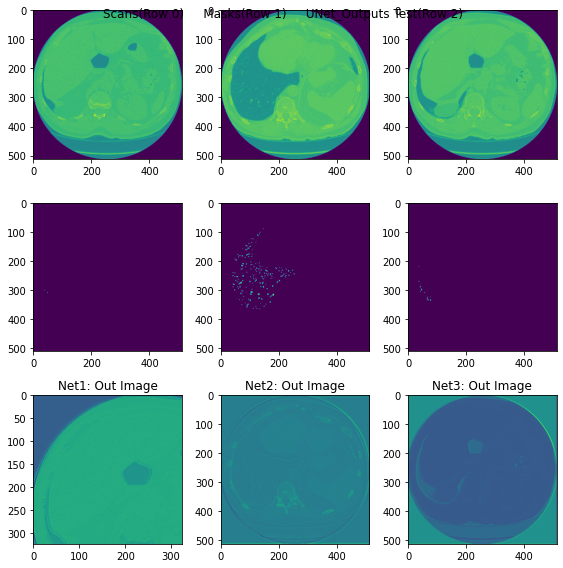

In [12]:
from torch._C import dtype
from SimpleITK.SimpleITK import Mask
""" 
Step 2.5: Visualize CT/CTA scans *If possible*
:input_data
"""

# Did this to re-update net everytime I tweaked optimizers
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create two versions to test with input data
net = UNet_V1().to(device) # This original paper implmentation reduces the image size

net2 = UNet_V2().to(device) # This version adds padding to match output

net3 = UNet().to(device) # This version made by Nat also idealizes the output but makes definition much smaller


# Quick visualization :)
fig ,ax = plt.subplots(3,3,figsize=(8,8))
fig.set_tight_layout(True)
fig.suptitle("Scans(Row 0)     Masks(Row 1)     UNet_Outputs Test(Row 2)")



# --------- NETWORK IN/OUT TESTING ------- #
for i, data in enumerate(trainLoader, 0):

  # Graph 4 instances of the input and label
  if i==3: break
  else:
    inputs, labels = data[0].to(device = device, dtype = torch.float), data[1].to(device = device, dtype = torch.float)

    ax[0][i].imshow(np.squeeze(np.squeeze(np.asarray(inputs.cpu().detach().numpy())))) 
    ax[1][i].imshow(np.squeeze(np.squeeze(np.asarray(labels.cpu().detach().numpy()))))

    if i == 0: 
      ax[2][i].imshow(np.squeeze(np.squeeze(np.asarray(net(inputs).cpu().detach().numpy()))))
    if i == 1: 
      ax[2][i].imshow(np.squeeze(np.squeeze(np.asarray(net2(inputs).cpu().detach().numpy()))))
    if i == 2: 
      ax[2][i].imshow(np.squeeze(np.squeeze(np.asarray(net3(inputs).cpu().detach().numpy()))))


# typeAndShape(output) 
ax[2][0].set_title("Net1: Out Image")
ax[2][1].set_title("Net2: Out Image")
ax[2][2].set_title("Net3: Out Image")



# <font color = Maroon> <b> Step 3 </b> </font> : Define Network, Lossfunction & Optimizer for training loop


In [22]:
""" 
Step 3: Training setup
"""

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Drop the networks form the above visualization block
# net.cpu()
# net2.cpu()
# net3.cpu()

# model = Unet().to(DEVICE, dtype = float)
model = UNet_V2().to(device=DEVICE, dtype = torch.float)


# UNCOMMENT FOR NETWORK PARAMTERS
# print("Total number of trainable CNN parameters=",sum([p.numel() for p in net_final.parameters()]))


################################################################################
# -------- TODO: Decide on optimal loss function and optimzers

lossfn = nn.BCEWithLogitsLoss()
learning_rate = .000095

# Idealized optimizers (From HW6 & Various trainings)
# op = optim.SGD(net_final.parameters(),lr = learning_rate, momentum=.9, dampening=.5, weight_decay = 0.0002)
# op =  optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay = 0.0006)
op = optim.Adam(model.parameters(), lr = learning_rate, betas = (.0045,.90), eps = .30, weight_decay = 0.00065)

# # Specify which optimzer here
optimizer = op

# <font color = Maroon> <b> Step 4 </b> </font> : Training & Validation
## <font color = Green Apple> NOTE 04/07/2022: Training code, state saving, accuracy testing replaced with Nat's implementation </font>

In [23]:
###### TRAINING HELPER FUNCTIONS ###### 

##### TRAINING LOOP
"""
Condensed training function
"""
def train_fn(loader, model, optimizer, loss_fn, scaler):
    # loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loader):
        data = data.to(DEVICE,dtype=torch.float)
        targets = targets.to(DEVICE,dtype=torch.float)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        # loop.set_postfix(loss=loss.item())

##### MODEL SAVING / LOADING
"""
Model saving
"""
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)
"""
Model loading
"""
def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

##### ACCURACY TESTING

"""
Accuracy of code based on Dice Score Coefficient (Sorensen-Dice Index)
"""
def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    # Calculating 'accuracy' across the pixels by comparing to mask
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device,dtype=torch.float)
            y = y.to(device,dtype=torch.float).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)

    print(f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}")
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()

##### SAVING OUTPUTS

""" 
Saving prediction images to local run time
"""    
def save_predictions_as_imgs(loader, model, folder="saved_images/", device="cuda"):
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device,dtype=torch.float)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(preds, f"{folder}/{idx}.png")   # Saves prediction
        torchvision.utils.save_image(y.float(), f"masks/{idx}.png")     # Saves mask
        torchvision.utils.save_image(x.float(), f"input/{idx}.png")     # Saves input
        

    model.train()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [24]:
# Use this to re-save/reset the predicitons
!rm -rf preds
!rm -rf masks
!rm -rf input

!mkdir preds
!mkdir masks
!mkdir input

In [25]:

"""
Step 4: Training and Validation
"""

import time


LOAD_MODEL = False
NUM_EPOCHS = 5

# Load model if available
if LOAD_MODEL:
    load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)

# Check its latest accuracy
# check_accuracy(trainLoader, model, device=DEVICE)
scaler = torch.cuda.amp.GradScaler()

# Log start time
start_time = time.time()

# Begin training
for epoch in range(NUM_EPOCHS):
    
    train_fn(trainLoader, model, optimizer, lossfn, scaler)

    # save model
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer":optimizer.state_dict(),
    }
    save_checkpoint(checkpoint)

    # check accuracy
    check_accuracy(testLoader, model, device=DEVICE)

    # print some examples to a folder
    save_predictions_as_imgs(
        testLoader, model, folder="preds/", device=DEVICE)

    print("Epoch: ", epoch)

time_elap = (time.time() - start_time) // 60
print('Finished Training in %d mins' % time_elap)

=> Saving checkpoint
Got 23735810/23855104 with acc 99.50
Dice score: 0.3453410267829895
Epoch:  0
=> Saving checkpoint
Got 23744356/23855104 with acc 99.54
Dice score: 0.40551644563674927
Epoch:  1
=> Saving checkpoint
Got 23753739/23855104 with acc 99.58
Dice score: 0.4028085768222809
Epoch:  2
=> Saving checkpoint
Got 23761287/23855104 with acc 99.61
Dice score: 0.40031206607818604
Epoch:  3
=> Saving checkpoint
Got 23753156/23855104 with acc 99.57
Dice score: 0.44635266065597534
Epoch:  4
Finished Training in 8 mins


###<font color =maroon > OLD NEEDS TO BE UPDATED: Documenting the Training </font>

|Num Epochs| Loss Function | Train_Loss| Comments | Changes to Improve |
|----| ---- | ---- | ---- | ---- |
|1|torch.nn.L1Loss()|<b> 1.014 (Not <font color= blue>NaN</font>!)</b>| Bad, CPU was referenced (Still good loss)| N/A |
|1|torch.nn.L1Loss()|<b> .64 |Again, good loss but **bad visual comparison**| Harsher loss function, network weight stuff |


# <font color = Maroon> <b> Step 5 </b> </font> : Test dataset and accuracy



In [26]:
# Grab image references from the local files

directorys = ["input/","masks/","preds/"]
ImageReferences = []

print(os.getcwd())

for pwds in directorys:
  # os.chdir('~/content') Home directory
  os.chdir(pwds)
  ImageReferences.append(os.listdir())
  os.chdir(os.pardir)

# Check:
print(ImageReferences)
print(os.getcwd())


/content
[['45.png', '73.png', '46.png', '64.png', '74.png', '84.png', '28.png', '36.png', '39.png', '61.png', '4.png', '75.png', '83.png', '11.png', '35.png', '17.png', '55.png', '68.png', '81.png', '66.png', '3.png', '57.png', '38.png', '24.png', '53.png', '44.png', '86.png', '79.png', '13.png', '26.png', '20.png', '22.png', '29.png', '40.png', '58.png', '18.png', '71.png', '10.png', '14.png', '51.png', '59.png', '47.png', '87.png', '19.png', '6.png', '88.png', '48.png', '33.png', '8.png', '15.png', '70.png', '32.png', '30.png', '80.png', '50.png', '49.png', '27.png', '52.png', '7.png', '89.png', '5.png', '0.png', '23.png', '31.png', '60.png', '34.png', '65.png', '90.png', '85.png', '2.png', '41.png', '63.png', '69.png', '77.png', '21.png', '72.png', '78.png', '42.png', '25.png', '9.png', '37.png', '54.png', '43.png', '1.png', '56.png', '12.png', '82.png', '67.png', '62.png', '76.png', '16.png'], ['45.png', '73.png', '46.png', '64.png', '74.png', '84.png', '28.png', '36.png', '39.png

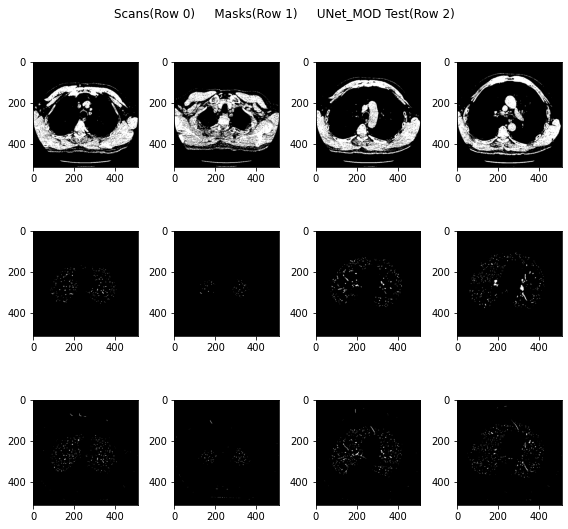

In [31]:
"""
Step 5: Visualizing output
"""

inputs = ImageReferences[0]
masks =  ImageReferences[1]
predictions =  ImageReferences[2]

# Grab the file from the local file folders

fig ,ax = plt.subplots(3,4,figsize=(8,8))
fig.set_tight_layout(True)
fig.suptitle("Scans(Row 0)     Masks(Row 1)     UNet_MOD Test(Row 2)")

for i in range(4):

  rand_indx = np.random.randint(0,len(testLoader)-1)
  tempIn = sitk.GetArrayFromImage(sitk.ReadImage("input/"+inputs[rand_indx]))
  tempMask = sitk.GetArrayFromImage(sitk.ReadImage("masks/"+masks[rand_indx]))
  tempPreds = sitk.GetArrayFromImage(sitk.ReadImage("preds/"+predictions[rand_indx]))


  ax[0][i].imshow(tempIn) 
  ax[1][i].imshow(tempMask)
  ax[2][i].imshow(tempPreds)


  
